<font size="6"> **Rule-Based Sentiment Factors in SEC 10-K Fillings** </font>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run ../nb_config.py

In [3]:
import nltk
import numpy as np
import pandas as pd
import scipy
import pickle
import pprint

import os

from tqdm import tqdm

In [4]:
from src import utils
from src.mle_quant_utils import mle_utils
from src.load_data import load_sec10k, io_utils
from src.nlp_quant import bow_sent

In [5]:
cfg = utils.read_conf()

In [6]:
INPATH1 = os.path.join(io_utils.interim_path, 'sec_fillings', '')
INPATH2 = os.path.join(io_utils.raw_path, 'market_data', cfg['quantopian']['dataset4']['folder'],'')
os.path.isdir(INPATH1), os.path.isdir(INPATH2)

(True, True)

In [7]:
INFILE1 = 'metadata.pkl'
INFILE2 = 'tenks_risk_tfidf_by_sent.pkl'
INFILE3 =  'parsed_sentiment_loughran_mcdonald.csv'
INFILE4 =  'tenks_risk_doc_len.csv'
INFILE5 = cfg['quantopian']['dataset4']['prices']
INFILE6 = cfg['output']['interim']['sector_factors']

In [8]:
OUTPATH =  os.path.join(io_utils.processed_path, 'sec_fillings', '')
os.path.isdir(OUTPATH)

True

In [9]:
OUTFILE1 = 'sec_10k_loughran_sent_alpha.csv'

In [10]:
example_ticker = 'amzn'

# Load Data

In [11]:
with open(INPATH1 + INFILE1, 'rb') as file:
    metadata = pickle.load(file)

In [12]:
tf_idf_by_sent = bow_sent.read_sent_tfidf_dict(path=INPATH1, name=INFILE2)

In [13]:
tf_idf_by_sent.keys()

dict_keys(['negative', 'positive', 'uncertainty', 'litigious', 'constraining', 'interesting'])

In [14]:
tf_idf_by_sent['negative'].iloc[0:2,0:10]

abandon  abandonment  abandonments  abdicate  abdication  \
ticker date                                                                   
aal    2003-04-15      0.0          0.0           0.0       0.0         0.0   
       2004-02-27      0.0          0.0           0.0       0.0         0.0   

                   abdications  aberrant  aberration  aberrational  \
ticker date                                                          
aal    2003-04-15          0.0       0.0         0.0           0.0   
       2004-02-27          0.0       0.0         0.0           0.0   

                   aberrations  
ticker date                     
aal    2003-04-15          0.0  
       2004-02-27          0.0

In [15]:
tf_idf_by_sent['negative'].iloc[:5,0]  # underlying pandas is an sparse data structure

ticker  date      
aal     2003-04-15    0.0
        2004-02-27    0.0
        2005-02-25    0.0
        2006-02-24    0.0
        2007-02-23    0.0
Name: abandon, dtype: Sparse[float64, 0.0]

In [16]:
doc_lens = pd.read_csv(INPATH1 + INFILE4, parse_dates=['date'], index_col=[0,1])['doc_len']

In [17]:
sentiment_df =  pd.read_csv(INPATH1 + INFILE3)

In [121]:
# Yearly pricing
pricing = pd.read_csv(INPATH2 + INFILE5, parse_dates=['date'])
pricing = pricing.pivot(index='date', columns='ticker', values='adj_close')

pricing.columns = [x.lower() for x in pricing.columns]
pricing = pricing.pct_change(1).shift(-1).stack().rename('1yr_fwd_rets')
pricing.index.names = ['date', 'ticker']

pricing.sample(5)

date        ticker
2004-01-01  wtt      -0.024637
2008-01-01  czz       1.514451
2007-01-01  hope     -0.149638
2017-01-01  khi       0.000000
2004-01-01  tip       0.024944
Name: 1yr_fwd_rets, dtype: float64

In [20]:
SECTOR_FOLDER = cfg['quantopian']['dataset1']['sector_folder']
SECTOR_NAMES = cfg['quantopian']['dataset1']['sector_names']

# Specify the bundle path
sector_file = os.path.join(io_utils.raw_path, 'market_data',SECTOR_FOLDER, SECTOR_NAMES)

In [21]:
sector_names = pd.read_csv(sector_file, usecols=['Sector', 'sector_id'], index_col='sector_id')
sector_names.loc[-1, 'Sector'] = 'No sector'
sector_names = sector_names.drop_duplicates()

sector_names

,Sector
sector_id,
0,Healthcare
1,Technology
2,Consumer Defensive
3,Industrials
4,Utilities
5,Financial Services
6,Real Estate
7,Communication Services
8,Consumer Cyclical


In [22]:
sector_factor_df = pd.read_csv(io_utils.interim_path + INFILE6, parse_dates=['date'], index_col=[0,1])

sector_factor_df = sector_factor_df.reset_index().merge(sector_names, how='left', left_on='sector_code', right_index=True).\
    set_index(keys=['date', 'asset'])[['sector_code', 'Sector']]
sector_factor_df.columns = ['sector_code', 'sector']

pd.concat([sector_factor_df.head(2), sector_factor_df.tail(2)], axis=0)

sector_code              sector
date                      asset                                 
2013-01-03 00:00:00+00:00 A                0          Healthcare
                          AAL              3         Industrials
2015-12-28 00:00:00+00:00 ZION             5  Financial Services
                          ZTS              0          Healthcare

In [23]:
# Mapping from asset to sector (no date)
sector_to_asset = sector_factor_df.reset_index('asset').drop_duplicates().set_index('asset')

pd.concat([sector_to_asset.head(2), sector_to_asset.tail(2)], axis=0)

,sector_code,sector
asset,,
A,0,Healthcare
AAL,3,Industrials
HPE,1,Technology
CSRA,1,Technology


# Rule Based Sentiment Analysis: Loughran Mcdonald textual analysis in financial data

Leverage expert crafted sentiments word lists to analyze create alpha factors. Two approaches:

* For a given ticker's 10k's document, measure evolution at each sentiment by computing similiarity among doc[t] and doc[t+1]
* Compute a sentiment score based on frequencies of each sentiment word list on each ticker 10k. Then standardize scores to obtain an alpha factor by each document



Referene: https://sraf.nd.edu/textual-analysis/resources/

In [24]:
sentiments = sentiment_df.columns.tolist()[:-1]
sentiments

['negative',
 'positive',
 'uncertainty',
 'litigious',
 'constraining',
 'interesting']

In [25]:
sentiment_df[sentiments].sum(axis=0)

negative        1515
positive         249
uncertainty      230
litigious        716
constraining      96
interesting       60
dtype: int64

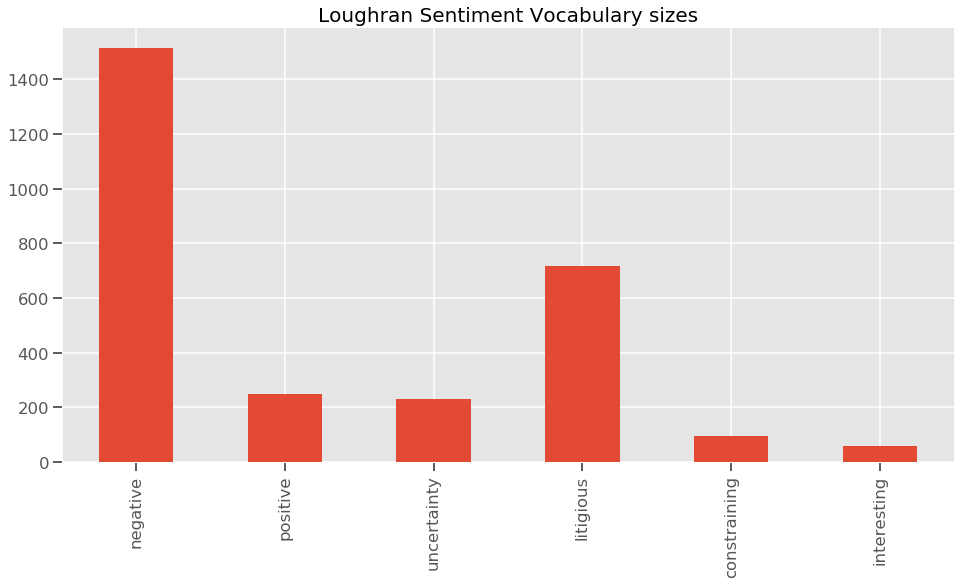

In [26]:
sent_vocab_sizes = sentiment_df[sentiments].sum(axis=0)
sent_vocab_sizes.plot.bar(title='Loughran Sentiment Vocabulary sizes')
plt.show()

## Sentiment Scores: TF-IDF

Firstly, aggregate tf-idf scores for each doc-sentiment (on each date). As sentiment vocabulary is considerabily varies, perform a zscore on date axis, that's it, by aggregating on each date each sentiment score

In [27]:
#['negative', 'positive', 'uncertainty', 'litigious', 'constraining', 'interesting'])
sent_score_sign = {'negative': -1,
                'uncertainty': -1,
                'litigious': -1,
                'constraining': -1,
                'positive': +1,
                'interesting': +1}
# Assumpmtion: Negative sentiments are asigned a negative raw alpha value,
# however, as they are then zscored, it is assumed that low z-scored values yield positive forward returns
# and high z-score values greater than zero ones

In [28]:
sent_score_dfs =  {}

for sent_key, tfidf_mat in tf_idf_by_sent.items():  #.div(doc_lens)
    sent_raw_score = tfidf_mat.sum(axis=1)  # * sent_score_sign[sent_key] # sentiment raw score by ticker-date
    sent_raw_score.name = 'sentiment_score'
    sent_score_dfs[sent_key] = sent_raw_score

In [66]:
ex_cols = [example_ticker, 'aapl']

neg_ex = sent_score_dfs['negative'].loc[ex_cols].reset_index().rename(columns={'sentiment_score': 'negative'})
pos_ex = sent_score_dfs['positive'].loc[ex_cols].reset_index()[['sentiment_score']].rename(columns={'sentiment_score': 'positive'})
sent_raw_ex = neg_ex.join(pos_ex).set_index(['ticker', 'date']).join(doc_lens)

In [67]:
sent_raw_ex.sample(10)

negative  positive  doc_len
ticker date                                   
amzn   2009-01-30  7.620281  4.665822    37348
       2004-02-25  3.716272  2.568835    30859
       2008-02-11  7.303306  4.441318    36509
       2018-02-02  7.208365  4.607825    40085
aapl   2016-10-26  6.926778  3.533796    39325
       2002-12-19  1.000000  1.000000      162
       2003-12-19  1.000000  1.000000      180
       2019-10-31  7.848082  3.575098    33711
amzn   2006-02-17  7.498047  4.359964    42004
aapl   2010-10-27  4.769857  3.391682    32345

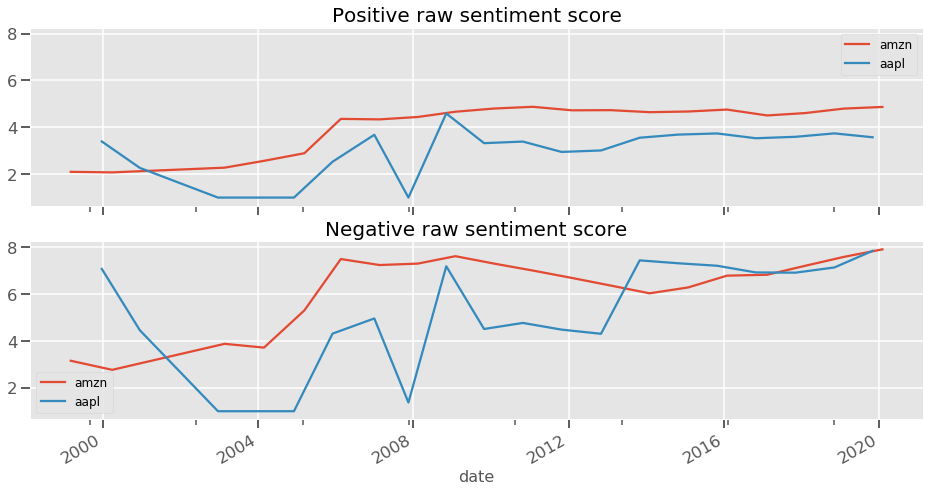

In [46]:
fig, axs = plt.subplots(2,1, sharey=True, sharex=True)

ax1 = axs[0]
sent_score_dfs['positive'][example_ticker].plot(ax=ax1, title='Positive raw sentiment score', label='amzn')
sent_score_dfs['positive']['aapl'].plot(ax=ax1, label='aapl')
ax1.legend()

ax2 = axs[1]
sent_score_dfs['negative'][example_ticker].plot(ax=ax2, title='Negative raw sentiment score', label='amzn')
sent_score_dfs['negative']['aapl'].plot(ax=ax2, label='aapl')
ax2.legend()

plt.show()

### Analyze sentiment score distribution

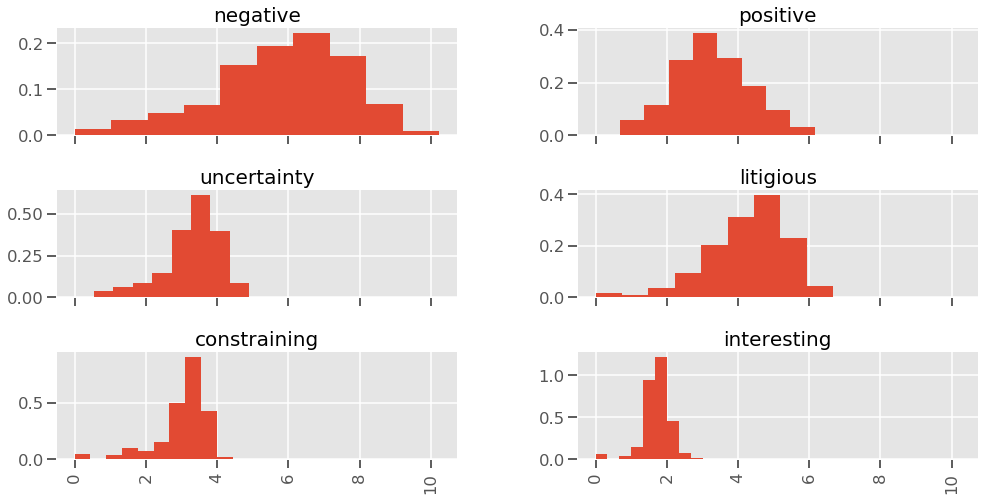

In [29]:
sent_by_score = pd.concat(sent_score_dfs).to_frame()
sent_by_score.index.set_names(inplace=True, names='sentiment', level=0)
sent_by_score.hist(by='sentiment', sharex=True, density=True)
plt.show()

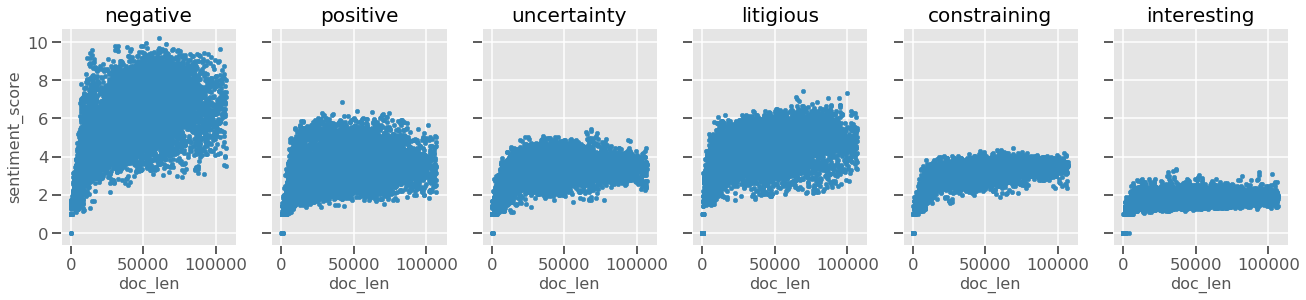

In [30]:
fig, axs = plt.subplots(1,len(sentiments), sharex=True, sharey=True, figsize=(22, 4))

for i, sentiment in enumerate(sentiments):
    join_data = sent_score_dfs[sentiment].to_frame().join(doc_lens[doc_lens<doc_lens.quantile(0.95)])
    ax = axs[i]
    join_data.plot.scatter(x='doc_len', y='sentiment_score', ax=ax)
    ax.set_title(sentiment)

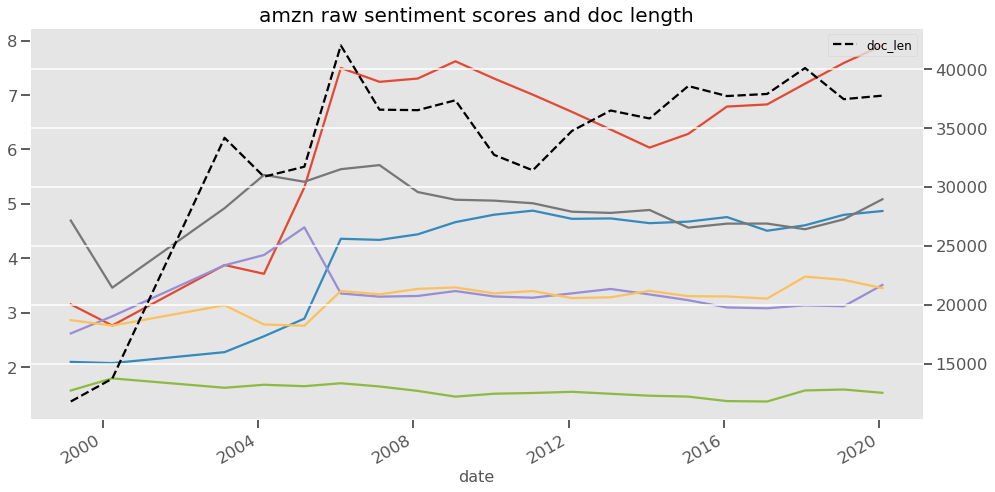

In [39]:
fig, ax1 = plt.subplots(1,1)
for sent_idx, raw_sent_score in sent_score_dfs.items():
    sent_score_dfs[sent_idx][example_ticker].plot(label=f'amzn {sent_idx}', ax=ax1)

doc_lens.loc[example_ticker].plot(secondary_y=True, linestyle='--', color='black', ax=ax1)
plt.title(f'{example_ticker} raw sentiment scores and doc length')
plt.legend()
plt.show()

Looking at AMZN data it seems that there may be correlation between doc size and each computed sentiment score

In [32]:
raw_sent_score_docsize = pd.concat(sent_score_dfs, axis=1).join(doc_lens)
raw_sent_score_docsize_corr = raw_sent_score_docsize.corr()

In [33]:
median_by_ticker_raw_sent_score_docsize_corr = raw_sent_score_docsize.groupby('ticker').corr().groupby('ticker').apply(lambda x: x.loc[(x.name, 'doc_len'), sentiments].median())
median_by_ticker_doc_len = doc_lens.groupby('ticker').median()

C:\ProgramData\Anaconda3\envs\quant-tsa\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


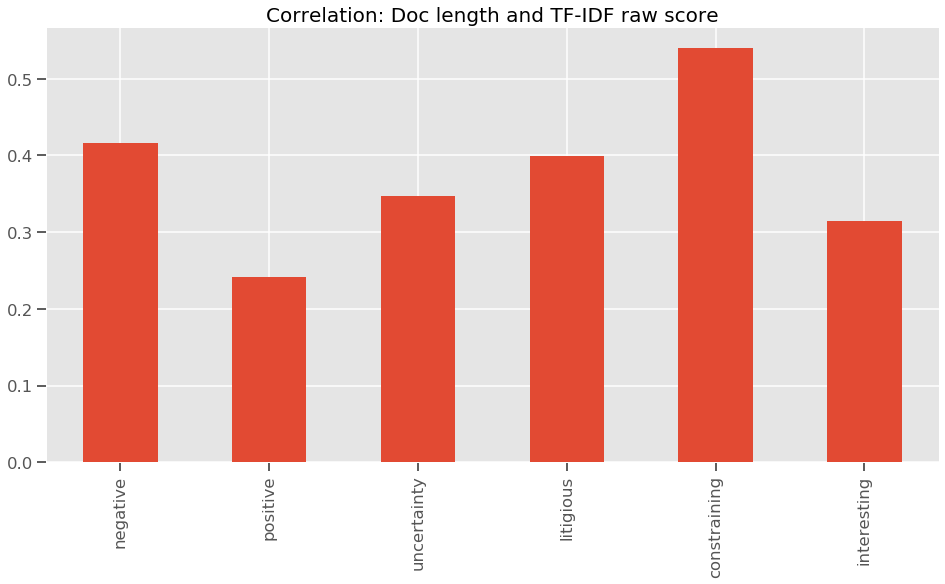

In [34]:
raw_sent_score_docsize_corr.loc['doc_len', sentiments].plot.bar()
plt.title('Correlation: Doc length and TF-IDF raw score')
plt.show()

It seems that each sentiment is strongly correlated with document size, specially `negative` and `constraining`. Instead of computing a global correlation, let's calculate correlation metrics by ticker, by getting a median for each sentiment

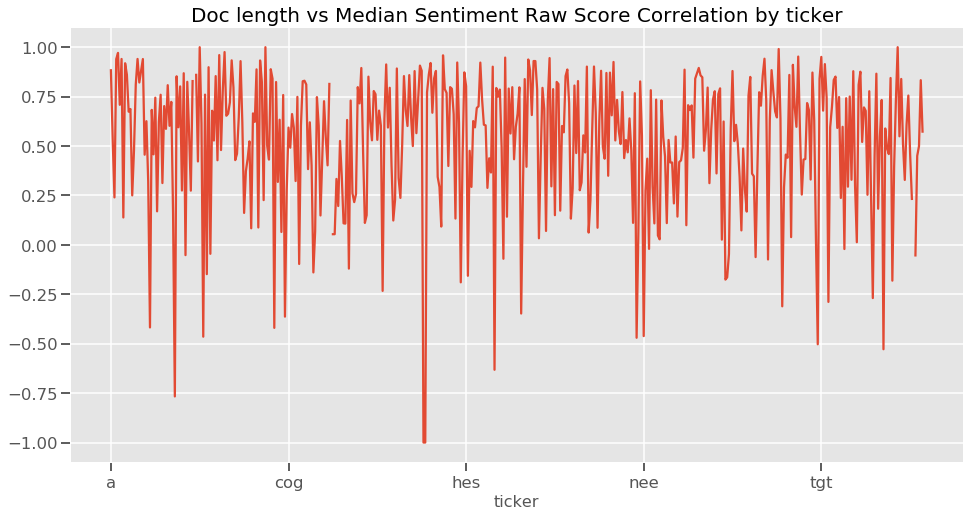

In [35]:
median_by_ticker_raw_sent_score_docsize_corr.plot()
plt.title('Doc length vs Median Sentiment Raw Score Correlation by ticker')
plt.show()

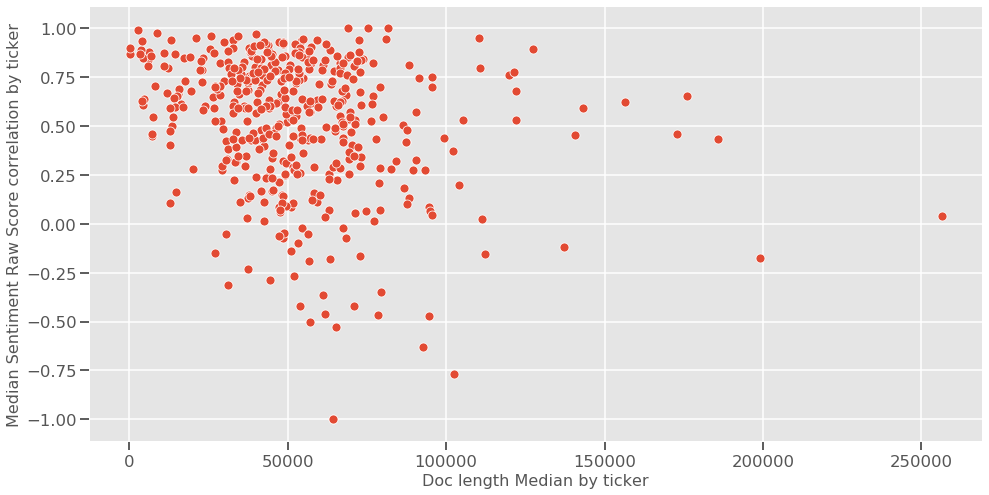

In [36]:
sns.scatterplot(x=median_by_ticker_doc_len.values, y =median_by_ticker_raw_sent_score_docsize_corr.values)
plt.ylabel('Median Sentiment Raw Score correlation by ticker')
plt.xlabel('Doc length Median by ticker')

plt.show()

In [90]:
sent_score_sca_dfs = {key: val.div(doc_lens).rename("sentiment_score") for key, val in sent_score_dfs.items()}

In [232]:
sent_alphas_raw = pd.concat(sent_score_sca_dfs, axis=1)
sent_alphas_raw.index.rename(inplace=True, names=['ticker', 'date_filling'])
sent_alphas_raw['date'] = [pd.Timestamp(str(x)) for x in sent_alphas_raw.index.get_level_values('date_filling').year]

## Sentiment Scores Difference

In [218]:
sent_score_sca_dir_dfs = {key: val.groupby('ticker').pct_change().dropna() for key, val in sent_score_sca_dfs.items()}

In [229]:
sent_alphas_raw_dir = pd.concat(sent_score_sca_dir_dfs, axis=1)
sent_alphas_raw_dir.index.rename(inplace=True, names=['ticker', 'date_filling'])
sent_alphas_raw_dir['date'] = [pd.Timestamp(str(x)) for x in sent_alphas_raw_dir.index.get_level_values('date_filling').year]

## Raw Sentiment Score and Difference Correlation

In [244]:
sentiments_chg = [f'{x}_chg' for x in sentiments]

sent_alphas_raw_and_dir = sent_alphas_raw.join(sent_alphas_raw_dir[sentiments].add_suffix('_chg'))
sent_alphas_raw_and_dir_prices = sent_alphas_raw_and_dir.merge(pricing, left_on=['date', 'ticker'], right_on=['date', 'ticker'])

pd.concat([sent_alphas_raw_and_dir_prices.head(2), sent_alphas_raw_and_dir_prices.tail(2)], axis=0)

,negative,positive,uncertainty,litigious,constraining,interesting,date,negative_chg,positive_chg,uncertainty_chg,litigious_chg,constraining_chg,interesting_chg,1yr_fwd_rets
ticker,,,,,,,,,,,,,,
aal,0.000144,0.000079,0.000119,0.000182,0.000136,0.000090,2005-01-01,-0.099720,-0.002711,-0.036475,0.050650,-0.032267,-0.028234,0.449919
aal,0.000156,0.000069,0.000087,0.000144,0.000090,0.000041,2006-01-01,0.081821,-0.132929,-0.267895,-0.210050,-0.340320,-0.544352,-0.726834
zts,0.000094,0.000044,0.000058,0.000086,0.000052,0.000031,2016-01-01,-0.021056,0.040205,0.022388,-0.086295,-0.036516,0.138699,0.355462
zts,0.000125,0.000048,0.000074,0.000101,0.000058,0.000037,2017-01-01,0.328354,0.098202,0.275004,0.175182,0.114577,0.218678,0.199605


In [265]:
corr_by_ticker = sent_alphas_raw_and_dir_prices.groupby('ticker').corr()
corr_by_ticker = corr_by_ticker.xs(key='1yr_fwd_rets', level=1)[sentiments + sentiments_chg]

corr_by_ticker.describe()
# sentiment scores or score change does not show a direct relationship to 1yr forward returns

,negative,positive,uncertainty,litigious,constraining,interesting,negative_chg,positive_chg,uncertainty_chg,litigious_chg,constraining_chg,interesting_chg
count,447.000000,447.000000,447.000000,447.000000,447.000000,447.000000,443.000000,443.000000,443.000000,443.000000,443.000000,443.000000
mean,0.029034,0.019104,0.043396,0.021352,0.023484,0.040704,0.024657,0.038170,0.016246,0.016254,0.016863,0.016546
std,0.318208,0.325930,0.323868,0.326143,0.327738,0.327838,0.316448,0.324726,0.332953,0.338585,0.335812,0.333332
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.156202,-0.174443,-0.137793,-0.161951,-0.177835,-0.155215,-0.141813,-0.150138,-0.186898,-0.193092,-0.179261,-0.193547
50%,0.021178,0.017304,0.029747,0.030989,0.019377,0.037842,0.032669,0.043267,0.023552,0.008590,0.012411,0.001421
75%,0.229238,0.219955,0.241139,0.218779,0.221991,0.233812,0.210580,0.228918,0.206037,0.223903,0.224348,0.226169
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [247]:
corr_by_ticker_vs_doclen = corr_by_ticker.join(doc_lens.groupby('ticker').median())

corr_by_ticker_vs_doclen.describe()
# in addition, the lack of correlation is not due document size skew

,negative,positive,uncertainty,litigious,constraining,interesting,negative_chg,positive_chg,uncertainty_chg,litigious_chg,constraining_chg,interesting_chg,doc_len
count,447.000000,447.000000,447.000000,447.000000,447.000000,447.000000,443.000000,443.000000,443.000000,443.000000,443.000000,443.000000,449.000000
mean,0.029034,0.019104,0.043396,0.021352,0.023484,0.040704,0.024657,0.038170,0.016246,0.016254,0.016863,0.016546,52379.446548
std,0.318208,0.325930,0.323868,0.326143,0.327738,0.327838,0.316448,0.324726,0.332953,0.338585,0.335812,0.333332,29180.564240
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,145.000000
25%,-0.156202,-0.174443,-0.137793,-0.161951,-0.177835,-0.155215,-0.141813,-0.150138,-0.186898,-0.193092,-0.179261,-0.193547,36494.500000
50%,0.021178,0.017304,0.029747,0.030989,0.019377,0.037842,0.032669,0.043267,0.023552,0.008590,0.012411,0.001421,48711.500000
75%,0.229238,0.219955,0.241139,0.218779,0.221991,0.233812,0.210580,0.228918,0.206037,0.223903,0.224348,0.226169,65201.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,256408.000000


In [282]:
corr_by_ticker.loc[corr_by_ticker['positive']>0.1].shape

(166, 12)

In [283]:
corr_by_ticker.loc[corr_by_ticker['negative']>0.1].shape

(181, 12)

In [280]:
corr_by_ticker.loc[corr_by_ticker['positive_chg']>0.1].shape

(184, 12)

In [281]:
corr_by_ticker.loc[corr_by_ticker['negative_chg']<-0.1].shape

(132, 12)

Even though computing correlation on the full set of stocks does not yield a clear result, there are sets of stocks which indeed are strongly correlated to this scores. In general, these sentiments may be good alpha factors only consiering subsets of stocks, not a broad stocks universe

# Compute Alpha-Factor

Negative sentiments values should be multiplied by -1 to invert relationship direction

## Scaled Sentiment Score

In [93]:
sent_alphas_raw = pd.concat(sent_score_sca_dfs)
sent_alphas_raw.index.rename(inplace=True, level=0, names='sentiment')
sent_alphas_raw = sent_alphas_raw.reset_index()
sent_alphas_raw['idx_year'] = sent_alphas_raw['date'].dt.year
sent_alphas_raw['asset'] = [ticker.upper() for ticker in sent_alphas_raw['ticker']]

sent_alphas_raw = sent_alphas_raw.merge(sector_to_asset, how='left', left_on='asset', right_on='asset').set_index(['sentiment', 'ticker', 'date'])
sent_alphas_raw['sector_code'] = sent_alphas_raw['sector_code'].fillna(-1)
sent_alphas_raw['sector'] = sent_alphas_raw['sector'].fillna('No sector')

sent_alphas_raw.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 51822 entries, ('negative', 'aal', Timestamp('2003-04-15 00:00:00')) to ('interesting', 'zts', Timestamp('2020-02-13 00:00:00'))
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sentiment_score  51816 non-null  float64
 1   idx_year         51822 non-null  int64  
 2   asset            51822 non-null  object 
 3   sector_code      51822 non-null  int64  
 4   sector           51822 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 2.3+ MB


In [94]:
pd.concat([sent_alphas_raw.head(2), sent_alphas_raw.tail(2)], axis=0)

sentiment_score  idx_year asset  sector_code  \
sentiment   ticker date                                                       
negative    aal    2003-04-15         0.000176      2003   AAL            3   
                   2004-02-27         0.000160      2004   AAL            3   
interesting zts    2019-02-14         0.000035      2019   ZTS            0   
                   2020-02-13         0.000039      2020   ZTS            0   

                                    sector  
sentiment   ticker date                     
negative    aal    2003-04-15  Industrials  
                   2004-02-27  Industrials  
interesting zts    2019-02-14   Healthcare  
                   2020-02-13   Healthcare

In [95]:
sent_alphas_count = sent_alphas_raw.groupby(['idx_year']).size()
#sent_alphas_count.name = 'count'
#sns.lineplot(data=sent_alphas_count.reset_index().drop_duplicates(), x='idx_year', y='count')
#plt.title('Total number of documents by year (ticker-date)')
#plt.show()

In [96]:
sent_alphas = pd.DataFrame(index=sent_score_dfs[sentiments[0]].index, columns=sentiments, dtype=float)
for sentiment in sentiments:
    sent_alphas[sentiment] = mle_utils.compute_sentiment_alpha_factor(
        sent_scores=sent_alphas_raw.loc[sentiment], date_col='idx_year',
        sector_col='sector_code', score_col='sentiment_score'
    ) * sent_score_sign[sentiment]
# add raw and raw_diff

In [149]:
sent_score_sign

{'negative': -1,
 'uncertainty': -1,
 'litigious': -1,
 'constraining': -1,
 'positive': 1,
 'interesting': 1}

In [97]:
pd.concat([sent_alphas.head(2), sent_alphas.tail(2)], axis=0)

negative  positive  uncertainty  litigious  constraining  \
ticker date                                                                   
aal    2003-04-15  1.312230 -0.523057     1.266348   0.321177      0.256942   
       2004-02-27  0.541693 -0.860336     0.678254   0.241259     -0.068281   
zts    2019-02-14 -0.333013 -0.065072    -0.945452  -0.914830     -0.868897   
       2020-02-13  0.222542 -0.995143     1.314260   1.188293      0.205747   

                   interesting  
ticker date                     
aal    2003-04-15    -0.568942  
       2004-02-27    -0.086489  
zts    2019-02-14     0.447845  
       2020-02-13     0.810390

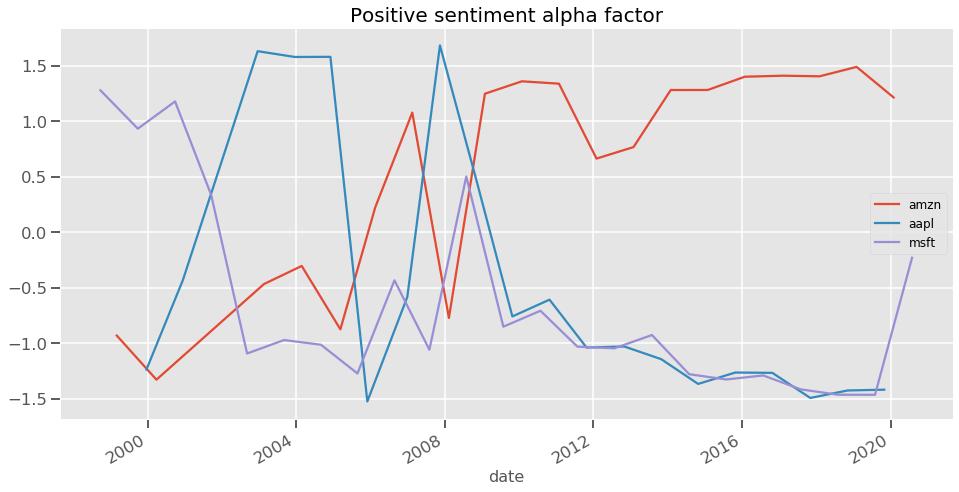

In [98]:
sent_alphas.loc[example_ticker, 'positive'].plot(title='Positive sentiment alpha factor', label='amzn')
sent_alphas.loc['aapl', 'positive'].plot(label='aapl')
sent_alphas.loc['msft', 'positive'].plot(label='msft')
plt.legend()
plt.show()

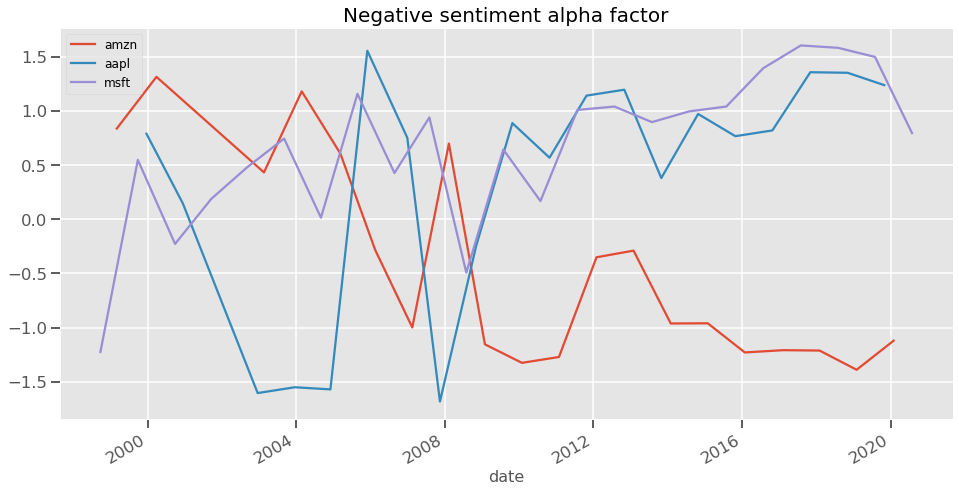

In [99]:
sent_alphas.loc[example_ticker, 'negative'].plot(title='Negative sentiment alpha factor', label='amzn')
sent_alphas.loc['aapl', 'negative'].plot(label='aapl')
sent_alphas.loc['msft', 'negative'].plot(label='msft')
plt.legend()
plt.show()

In [133]:
sent_alphas.merge(pricing, left_on=['date_idx', 'ticker'], right_on=['date', 'ticker']).loc['amzn'].corr()

,negative,positive,uncertainty,litigious,constraining,interesting,1yr_fwd_rets
negative,1.000000,-0.963300,0.962373,0.708167,0.634670,-0.487748,-0.218169
positive,-0.963300,1.000000,-0.955291,-0.643818,-0.515644,0.489289,0.210670
uncertainty,0.962373,-0.955291,1.000000,0.750137,0.585042,-0.331327,-0.133850
litigious,0.708167,-0.643818,0.750137,1.000000,0.739658,-0.145909,0.054009
constraining,0.634670,-0.515644,0.585042,0.739658,1.000000,-0.502079,-0.234332
interesting,-0.487748,0.489289,-0.331327,-0.145909,-0.502079,1.000000,0.324815
1yr_fwd_rets,-0.218169,0.210670,-0.133850,0.054009,-0.234332,0.324815,1.000000


In [214]:
sent_alphas_raw_dir

sentiment_score
            ticker date                       
negative    aal    2004-02-27        -0.090406
                   2005-02-25        -0.099720
                   2006-02-24         0.081821
                   2007-02-23        -0.014440
                   2008-02-20        -0.117264
...                                        ...
interesting zts    2016-02-24         0.138699
                   2017-02-16         0.218678
                   2018-02-15        -0.016203
                   2019-02-14        -0.036411
                   2020-02-13         0.097490

[48824 rows x 1 columns]

In [175]:
sent_alphas['date_idx'] = [pd.Timestamp(str(x)) for x in sent_alphas.index.get_level_values('date').year]

corr_by_ticker = sent_alphas.merge(pricing, left_on=['date_idx', 'ticker'], right_on=['date', 'ticker']).groupby('ticker').corr()
corr_by_ticker = corr_by_ticker.xs(key='1yr_fwd_rets', level=1)[sentiments]
corr_by_ticker_vs_doclen = corr_by_ticker.join(doc_lens.groupby('ticker').median())

In [176]:
corr_by_ticker.loc['amzn']

negative       -0.218169
positive        0.210670
uncertainty    -0.133850
litigious       0.054009
constraining   -0.234332
interesting     0.324815
Name: amzn, dtype: float64

In [156]:
mask = ((corr_by_ticker['positive']>0.1) & (corr_by_ticker['negative']<-0.1))

In [157]:
corr_by_ticker.loc[mask].shape

(130, 6)

In [178]:
corr_by_ticker_vs_doclen.loc[mask].describe().T
#corr_by_ticker_vs_doclen

,count,mean,std,min,25%,50%,75%,max
negative,130.0,-0.316558,0.168190,-1.000000,-0.403894,-0.270337,-0.196917,-0.102629
positive,130.0,0.317219,0.175531,0.105659,0.199251,0.255340,0.410508,1.000000
uncertainty,130.0,-0.308856,0.199047,-1.000000,-0.421400,-0.277746,-0.166784,0.251701
litigious,130.0,-0.214112,0.295951,-1.000000,-0.385516,-0.197137,0.003221,0.504837
constraining,130.0,-0.074972,0.321343,-0.964269,-0.278696,-0.090075,0.116268,1.000000
interesting,130.0,0.015599,0.313966,-1.000000,-0.179534,0.001890,0.189038,0.981837
doc_len,130.0,51243.665385,24524.403962,2854.000000,35749.375000,51405.500000,65484.750000,143266.500000


In [170]:
doc_lens.describe()

count      8637.000000
mean      48487.666667
std       36375.509993
min           0.000000
25%       26496.000000
50%       44826.000000
75%       63711.000000
max      849836.000000
Name: doc_len, dtype: float64

In [173]:
corr_by_ticker_vs_doclen[corr_by_ticker_vs_doclen['doc_len']<40000]

,negative,positive,uncertainty,litigious,constraining,interesting,doc_len
ticker,,,,,,,
aapl,-0.368019,0.435344,-0.420586,0.504837,0.031604,-0.206608,33067.5
abt,0.047504,-0.128583,0.206725,0.106320,-0.217537,0.241621,32837.0
adi,-0.177004,0.191327,-0.172205,-0.332823,-0.265201,-0.221657,38831.0
adm,-0.551736,0.459523,-0.509016,-0.312478,-0.397625,0.414217,34244.5
adp,0.229786,-0.133417,0.166326,0.189748,0.265102,-0.024618,37502.0
...,...,...,...,...,...,...,...
vz,-0.422267,0.336276,-0.330123,-0.481582,-0.472118,0.459048,7365.0
wat,-0.207510,0.246260,-0.160607,-0.193839,-0.193025,0.222559,32510.0
wfc,-0.092386,-0.102289,0.237656,-0.188538,-0.028790,0.070814,7264.0


In [158]:
corr_by_ticker.loc[mask].describe().T

,count,mean,std,min,25%,50%,75%,max
negative,130.0,-0.316558,0.168190,-1.000000,-0.403894,-0.270337,-0.196917,-0.102629
positive,130.0,0.317219,0.175531,0.105659,0.199251,0.255340,0.410508,1.000000
uncertainty,130.0,-0.308856,0.199047,-1.000000,-0.421400,-0.277746,-0.166784,0.251701
litigious,130.0,-0.214112,0.295951,-1.000000,-0.385516,-0.197137,0.003221,0.504837
constraining,130.0,-0.074972,0.321343,-0.964269,-0.278696,-0.090075,0.116268,1.000000
interesting,130.0,0.015599,0.313966,-1.000000,-0.179534,0.001890,0.189038,0.981837


In [148]:
corr_by_ticker.describe().T

,count,mean,std,min,25%,50%,75%,max
negative,447.0,0.029886,0.315674,-1.0,-0.185987,0.013870,0.234850,1.0
positive,447.0,-0.026808,0.313468,-1.0,-0.219268,-0.004646,0.179443,1.0
uncertainty,447.0,0.016944,0.328292,-1.0,-0.191544,-0.002213,0.224975,1.0
litigious,447.0,0.016772,0.338858,-1.0,-0.200212,0.007771,0.239427,1.0
constraining,447.0,0.019580,0.307356,-1.0,-0.190462,0.031317,0.222586,1.0
interesting,447.0,-0.011227,0.313175,-1.0,-0.210949,-0.008835,0.180824,1.0


In [129]:
corr.loc[sentiments, '1yr_fwd_rets']

negative        0.014590
positive       -0.015617
uncertainty     0.012978
litigious       0.005770
constraining   -0.001375
interesting    -0.021788
Name: 1yr_fwd_rets, dtype: float64

# Write Data

In [ ]:
sent_alphas.to_csv(OUTPATH + OUTFILE1)